# Automatic calibration algorithm demo

Assumptions:

1. True distribution is $\mathcal{N}(0,\sigma^2)$
2. Forecaster's subjective distribution is $\mathcal{N}(0,\sigma_f^2)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hemlock import Compile, Embedded, Page, Input, push_app_context
from scipy import stats

import random

np.random.seed(0)
random.seed(0)

# stdev of the true distribution
TRUE_SCALE = .8
# stdev of the forecaster's subjective distribution
FCAST_SCALE = .4

# upper bounds for each bin
BINS = [-1.2, -.4, .4, 1.2, np.inf]
BINS_TXT = [
    'less than -1.2',
    '-1.2 to -.4',
    '-.4 to .4',
    '.4 to 1.2',
    'greater than 1.2',
]

push_app_context()

17:19:11: Server initialized for eventlet.


<Flask 'hemlock.app'>

## Elicit forecasts and run simulation

Preview elicitation page.

In [2]:
ELICITATION = """
<p>How likely is <i>x</i> to fall into the following bin: <b>{}</b>.</p>
"""

p0 = Page()
[Input(p0, label=ELICITATION.format(bin_), var='Forecast') for bin_ in BINS_TXT]

p0.preview('Ubuntu')

True

Input forecasts.

Text(0.5, 1.0, 'Raw forecasts')

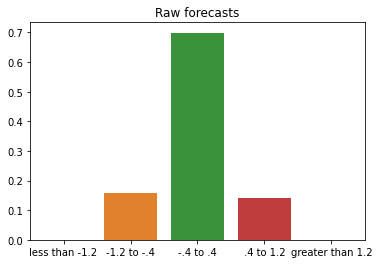

In [3]:
def get_draws_weights(scale, size=1000):
    draws = np.random.normal(scale=scale, size=size)
    pctiles = [0] + [stats.percentileofscore(draws, bin_) for bin_ in BINS]
    weights = np.diff(pctiles)
    return draws, weights/100

fcast_draws, y_fcast = get_draws_weights(scale=FCAST_SCALE)
[setattr(inpt, 'data', float(i)) for inpt, i in zip(p0.questions, y_fcast)]
sns.barplot(BINS_TXT, y_fcast)
plt.title('Raw forecasts')

Run simulation.

Text(0.5, 1.0, 'Simulated')

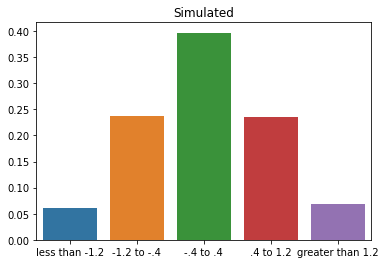

In [4]:
true_draws, y_true = get_draws_weights(scale=TRUE_SCALE)
[Embedded(p0, var='True', data=float(i)) for i in y_true]
sns.barplot(BINS_TXT, y_true)
plt.title('Simulated')

Compare simulated distribution to forecaster's subjective distribution.

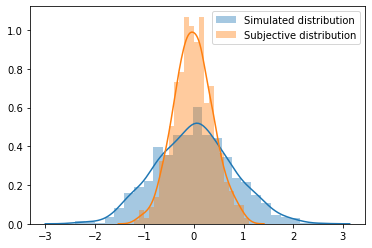

In [5]:
sns.distplot(true_draws, label='Simulated distribution')
sns.distplot(fcast_draws, label='Subjective distribution')
plt.legend()

## Train automatic calibration algorithm

/home/dsbowen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Brier score for raw forecasts: 0.1147
Brier score for calibrated forecasts: 0.0136


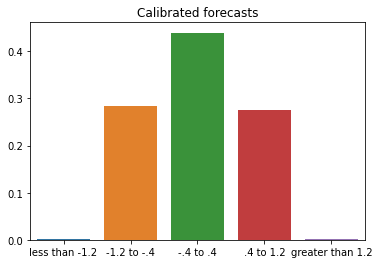

In [6]:
from scipy.optimize import minimize
from scipy.spatial import distance

EPSILON = .001

class Calibrator():
    def __init__(self, coef=5):
        self.coef = 5
    
    def __call__(self, y_fcast, normalize=True):
        adjusted = np.array(list(map(self.calibrate_fcast, y_fcast)))
        adjusted = np.maximum(adjusted, EPSILON*np.ones(len(y_fcast)))
        return adjusted / adjusted.sum() if normalize else adjusted
    
    def calibrate_fcast(self, x):
        # inverse logit
        return 1/self.coef * np.log(x/(1-x+EPSILON)) + .5
    
    def loss(self, coef=None):
        if coef is not None:
            self.coef = float(coef)
        return ((self(y_fcast) - y_true)**2).sum()
    
calibrator = Calibrator()
minimize(calibrator.loss, x0=5)

sns.barplot(BINS_TXT, calibrator(y_fcast))
plt.title('Calibrated forecasts')
print('Brier score for raw forecasts: %.4f' % ((y_true - y_fcast)**2).sum())
print('Brier score for calibrated forecasts: %.4f' % calibrator.loss())

/home/dsbowen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


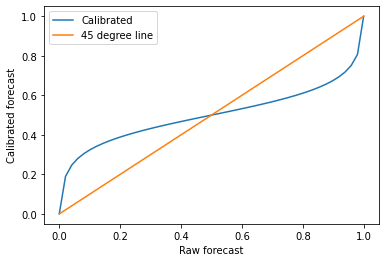

In [7]:
y_fcast = np.linspace(0,1)
adjusted = calibrator(y_fcast, normalize=False)
adjusted = np.minimum(adjusted, np.ones(len(adjusted)))
sns.lineplot(y_fcast, adjusted, label='Calibrated')
sns.lineplot(y_fcast, y_fcast, label='45 degree line')
plt.xlabel('Raw forecast')
plt.ylabel('Calibrated forecast')
plt.legend()

## Use algorithm to suggest better calibrated forecasts for next simulation

Preview elicitation page.

In [8]:
p1 = Page()
[Input(p1, label=ELICITATION.format(bin_), var='Forecast') for bin_ in BINS_TXT]
p1.preview('Ubuntu')

True

Input forecasts.

In [9]:
fcast_draws, y_fcast = get_draws_weights(scale=FCAST_SCALE)
[setattr(inpt, 'response', str(int(100*i))) for inpt, i in zip(p1.questions, y_fcast)]
[setattr(inpt, 'data', float(i)) for inpt, i in zip(p1.questions, y_fcast)]
y_fcast

array([0.001, 0.165, 0.695, 0.139, 0.   ])

Suggest better calibrated forecasts.

In [10]:
from hemlock import Compile

ADJUST = """
<p>Our algorithm suggests that a better calibrated forecast for this bin would be <b>{:.0f}%</b></p>
"""

@Compile.register
def adjust_fcasts(adjust_p, fcast_p):
    y_fcast = [q.data for q in fcast_p.questions]
    adjusted_fcasts = 100*calibrator(y_fcast)
    for i in range(len(BINS_TXT)):
        q = adjust_p.questions[i]
        q.label = ELICITATION.format(BINS_TXT[i])+ADJUST.format(adjusted_fcasts[i])
        q.default = fcast_p.questions[i].response
    
p2 = Page()
[Input(p2, var='AdjustedForecast') for _ in BINS_TXT]
Compile.adjust_fcasts(p2, fcast_p=p1)
p2._compile()
p2.preview('Ubuntu')

/home/dsbowen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


True

Run new simulation and compare Brier scores.

In [11]:
true_draws, y_true = get_draws_weights(scale=TRUE_SCALE)
print('Brier score for raw forecasts: %.4f' % ((y_true - y_fcast)**2).sum())
print('Brier score for calibrated forecasts: %.4f' % calibrator.loss())

Brier score for raw forecasts: 0.1282
Brier score for calibrated forecasts: 0.0184


/home/dsbowen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
